## Stock selection according to Hossein PTS Cointegration 
- we calculate the spread between the normalized prices of all possible combinations of stock pairs during the formation period. The formation period is chosen to be 12 months. 
- The normalized price is defined as the cumulative return index, adjusted for dividends and other corporate actions, and scaled to $1 at the beginning of the formation period. In the trading period, this price is used to calculate the spread. 
- We then select 20 of those combinations that have the least sum of squared spreads, or sum of squared differences (SSD), to form the nominated pairs to trade in the following trading period, that is chosen to be 6 months. The standard deviation of the spread during the formation period is also recorded and used as the trading criterion. A specific stock can participate in forming more than one pair as long as the other stock of the pair varies.
- then we test each of the pairs with the least SSD for cointegration,
by using their cumulative return series in the formation period. Pairs that are not cointegrated are eliminated in the selection process. Pairs that are cointegrated will have their cointegration coefficient estimated. We continue until 20 cointegrated pairs with minimum SSDs are selected to be traded in the following trading period
- After selecting nominated cointegrated pairs using the two-step Engle-Granger method (Engle and Granger, 1987), we extract their stationary spread.
- Thus, the profit of buying one share of stock 2 and selling beta share of stock 1 for the period delta t is given by the change in the spread for that period.

In [ ]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
import math 
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations
from cointegration_functions import * 

#stocks_1990_2025 = pd.read_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/stocks_1990_2025.csv", index_col = 0)
#backtest_result_1990_2025 = run_strategy_hossein(stocks_1990_2025)
#backtest_result_1990_2025.to_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/test_files/backtestfrom1990to2025_correct_result.csv")

118.12041281376072
(8309, 391)


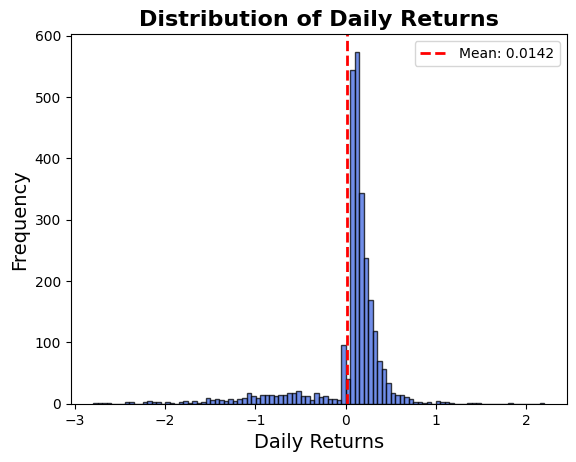

In [30]:
backtest_result_1990_2025=pd.read_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/backtestfrom1990to2025_correct_result.csv", index_col = 0)

# Daily returns of the 6 overlapping portfolios for the selected time frame. 
daily_returns = pd.DataFrame(backtest_result_1990_2025).sum(axis=1)
daily_returns_hist = daily_returns[daily_returns !=0]

print(sum(daily_returns))
print(backtest_result_1990_2025.shape)
plt.hist(daily_returns_hist, bins=100, color="royalblue", edgecolor="black", alpha=0.75)

# Labels and title
plt.xlabel("Daily Returns", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Daily Returns", fontsize=16, fontweight="bold")
plt.axvline(daily_returns.mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {daily_returns.mean():.4f}")
plt.legend()

## Return calculation - from daily to monthly
- Return on committed capital for month m, $RCC_m$ , is calculated
as the sum of marked-to-market returns on traded pairs divided by the number of pairs that were
nominated to trade in that month (20 in our case), regardless of whether they actually traded
or not.
- The monthly excess return of a strategy is calculated as
the equally weighted average return on these 6 portfolios.

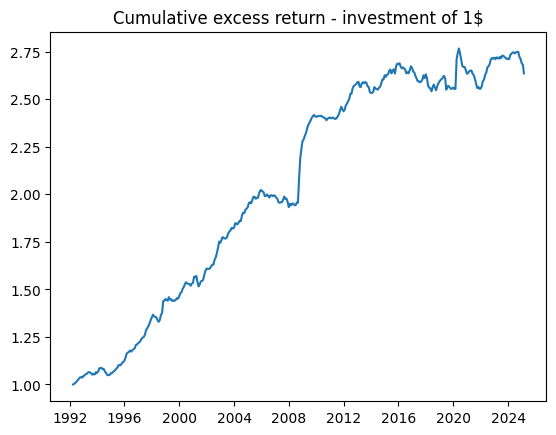

In [239]:
daily_returns.index = pd.to_datetime(daily_returns.index)
monthly_returns = daily_returns.resample("1ME").sum() / 20 # RCC, trade returns summed over given month and then divided by 20 
monthly_excess_returns = monthly_returns / 6 # because we have 6 portfolios 

plt.plot(np.cumprod(1+monthly_excess_returns))
plt.title(label="Cumulative excess return - investment of 1$")
plt.show()

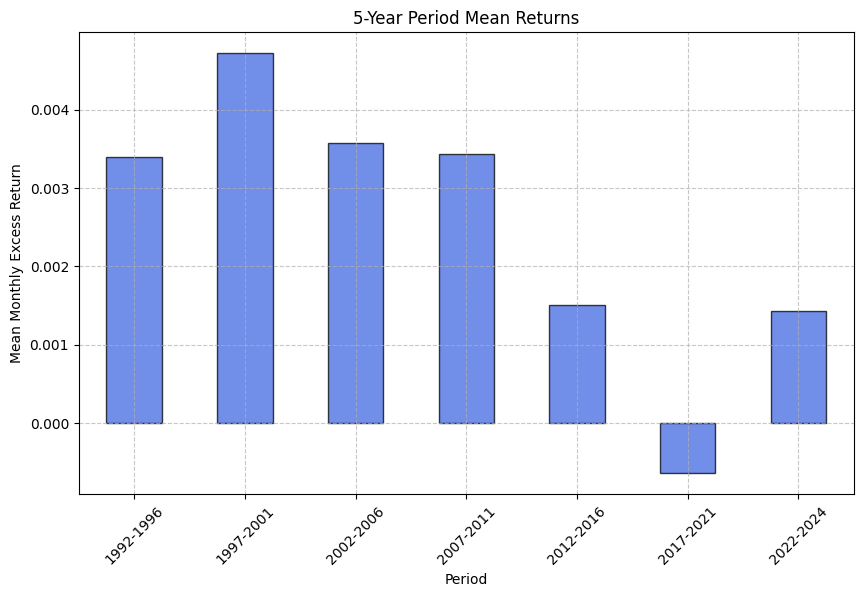

In [238]:
monthly_excess_returns = monthly_excess_returns[monthly_excess_returns.index <= "2025-01-01"]
monthly_excess_returns.index = pd.to_datetime(monthly_excess_returns.index)

def five_year_label(period):
    start = ((period.year - 1992) // 5) * 5 + 1992
    end = start + 4
    if end >= 2024:
        end = 2024
    return f"{start}-{end}"

group_labels = monthly_excess_returns.index.map(five_year_label)

monthly_excess_returns_5Y = monthly_excess_returns.groupby(group_labels).mean()

plt.figure(figsize=(10, 6))  # Adjust figure size for better clarity
monthly_excess_returns_5Y.plot(kind = "bar", color='royalblue', edgecolor='black', label='5-Year Mean Return', alpha = 0.75)
plt.xlabel("Period")
plt.ylabel("Mean Monthly Excess Return")
plt.title("5-Year Period Mean Returns")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

- This plot shows how the strategy performed throughout the years, note that turbulent years seem to be good for the strategy 

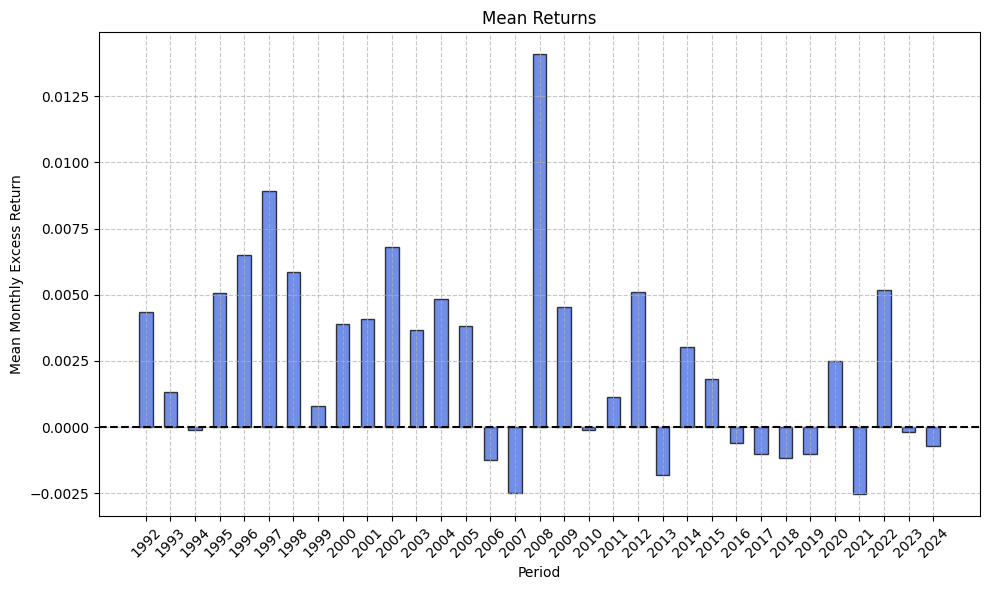

In [242]:
monthly_excess_returns = monthly_excess_returns[monthly_excess_returns.index <= "2025-01-01"]
yearly_returns_average = monthly_excess_returns.resample(rule = "1YE").mean()

# Bar plot of resampled mean returns
plt.figure(figsize=(10, 6))  # Adjust figure size for better clarity
plt.bar(yearly_returns_average.index, yearly_returns_average.values, width = 200, color='royalblue', edgecolor='black', alpha = 0.75)
plt.axhline(0, color='black', linestyle='--')  # Reference line at 0
plt.xlabel("Period")
plt.ylabel("Mean Monthly Excess Return")
plt.title("Mean Returns")
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-ticks to show just the year
plt.xticks(yearly_returns_average.index, [d.year for d in yearly_returns_average.index], rotation=45)

plt.tight_layout()
plt.show()

## Normal vs crisis period
- based on lowest quintile years of the SP&500 returns 

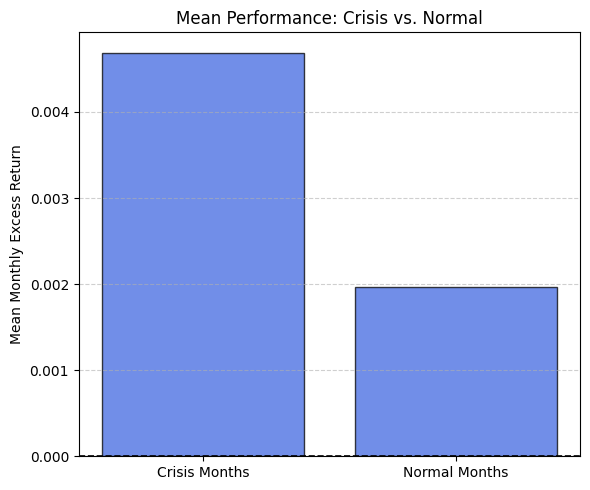

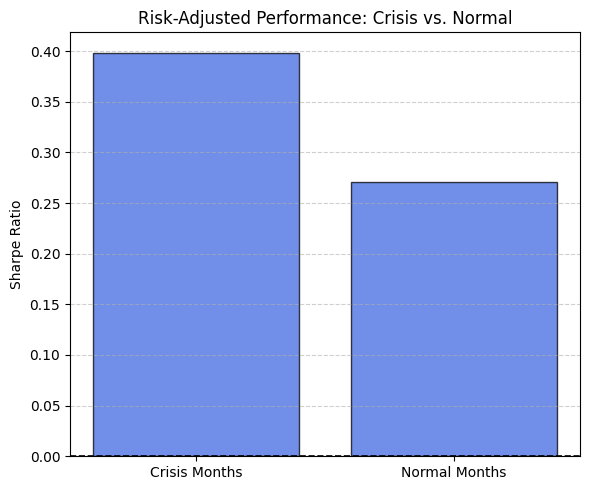

In [229]:
sp500_returns = pd.read_csv("./sp-500-historical-annual-returns.csv", index_col = 0)
sp500_returns.index = pd.to_datetime(sp500_returns.index)
sp500_returns = sp500_returns[(sp500_returns.index.year >= 1992) & (sp500_returns.index.year < 2025)] /100
sp500_returns = sp500_returns.sort_values(by="value",ascending=True)

threshold = sp500_returns['value'].quantile(0.2)  # 20th percentile

crisis_years = sp500_returns[sp500_returns['value'] <= threshold].index.year
normal_years = sp500_returns[sp500_returns['value'] > threshold].index.year

crisis_months = monthly_excess_returns[monthly_excess_returns.index.year.isin(crisis_years)]
normal_months = monthly_excess_returns[monthly_excess_returns.index.year.isin(normal_years)]

# Calculate mean returns
crisis_mean = crisis_months.mean()
crisis_sharpe = crisis_mean / crisis_months.std()
normal_mean = normal_months.mean()
normal_sharpe = normal_mean / normal_months.std()

# Plot 1: Mean Excess Return
plt.figure(figsize=(6, 5))
plt.bar(['Crisis Months', 'Normal Months'], [crisis_mean, normal_mean], 
        color='royalblue', edgecolor='black', alpha=0.75)
plt.axhline(0, color='black', linestyle='--', linewidth=1.2)
plt.ylabel("Mean Monthly Excess Return")
plt.title("Mean Performance: Crisis vs. Normal")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 2: Sharpe Ratio
plt.figure(figsize=(6, 5))
plt.bar(['Crisis Months', 'Normal Months'], [crisis_sharpe, normal_sharpe], 
        color='royalblue', edgecolor='black', alpha=0.75)
plt.axhline(0, color='black', linestyle='--', linewidth=1.2)
plt.ylabel("Sharpe Ratio")
plt.title("Risk-Adjusted Performance: Crisis vs. Normal")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

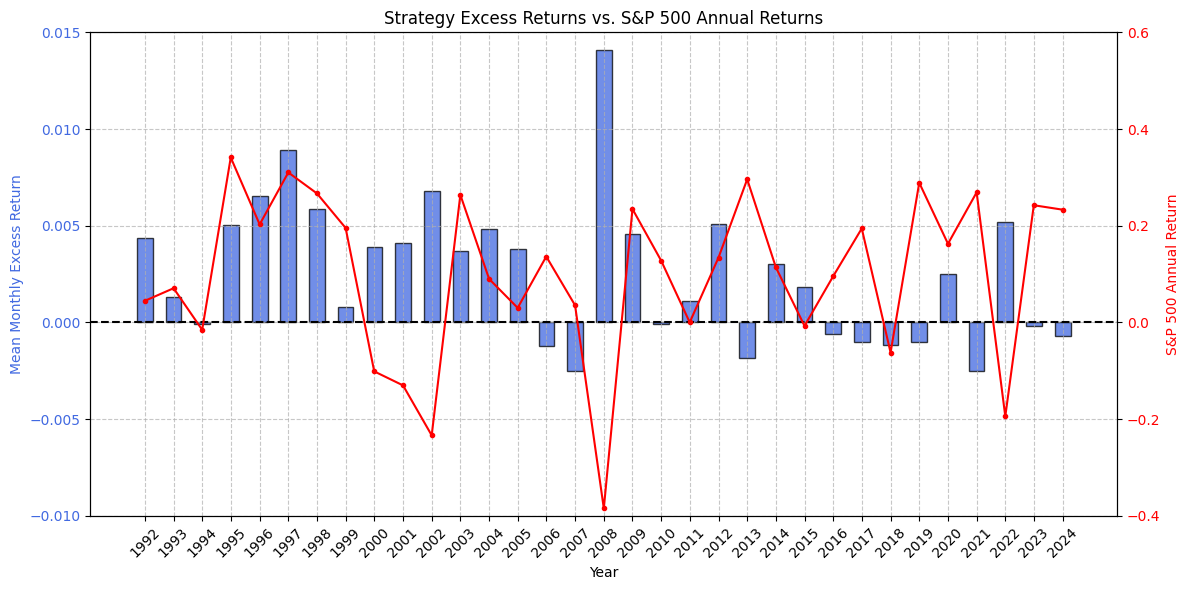

In [254]:
# Load S&P 500 data
sp500_returns = pd.read_csv("./sp-500-historical-annual-returns.csv", index_col=0)
sp500_returns.index = pd.to_datetime(sp500_returns.index)
sp500_returns = sp500_returns[(sp500_returns.index.year >= 1992) & (sp500_returns.index.year < 2025)] /100

# Filter and resample monthly excess returns
monthly_excess_returns = monthly_excess_returns[monthly_excess_returns.index <= "2025-01-01"]
yearly_returns_average = monthly_excess_returns.resample("1YE").mean()

# Plot with dual axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for monthly excess returns (left y-axis)
ax1.bar(yearly_returns_average.index, yearly_returns_average.values.flatten(), width=200,
        color='royalblue', edgecolor='black', label="Strategy Excess Return", alpha = 0.75)
ax1.set_ylabel("Mean Monthly Excess Return", color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.axhline(0, color='black', linestyle='--')
ax1.set_xlabel("Year")
ax1.set_xticks(yearly_returns_average.index)
ax1.set_xticklabels([d.year for d in yearly_returns_average.index], rotation=45)
ax1.set_ylim(-0.01,0.015)


# Line plot for S&P 500 returns (right y-axis)
ax2 = ax1.twinx()
# Get the position of 0 on the left axis in display coordinates
y0_display = ax1.transData.transform((0, 0))[1]

# Convert that display coordinate to a data coordinate on the right axis
zero_on_ax2 = ax2.transData.inverted().transform((0, y0_display))[1]

# Get current y-limits of ax2
y2min, y2max = ax2.get_ylim()

# Shift ax2 limits to center 0 at the same vertical height as ax1
dy = zero_on_ax2
ax2.set_ylim(y2min - dy , y2max - dy)

ax2.plot(sp500_returns.index, sp500_returns['value'].values.flatten(), color='red', label="S&P 500 Return", linewidth = 1.5, marker = ".", linestyle = "-")
ax2.set_ylabel("S&P 500 Annual Return", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title("Strategy Excess Returns vs. S&P 500 Annual Returns")
ax1.grid(True, linestyle='--', alpha=0.7)

fig.tight_layout()
plt.show()